In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

## Download dataset for training ML models

In [2]:
batch_size = 8
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)                            

100%|████████████████████████████████████████| 170M/170M [00:02<00:00, 70.2MB/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

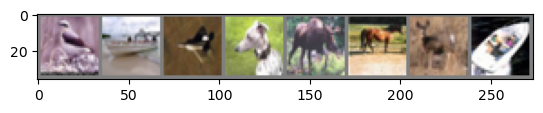

bird  ship  plane dog   deer  horse deer  ship 


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

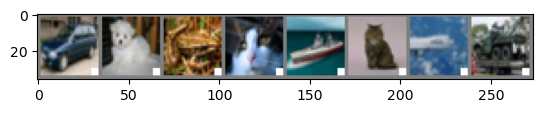

Image with backdoor trigger:car   dog   frog  cat   ship  cat   plane truck


In [7]:

# Define a simple backdoor trigger (white square)
def add_backdoor_trigger(image):
    # Create a white square (e.g., 4x4 pixels) in the bottom-right corner
    trigger_size = 4
    trigger_value = 1.0  # White pixel value
    image_size = image.shape[-1]
    trigger_x = image_size - trigger_size
    trigger_y = image_size - trigger_size

    # Modify the image by adding the trigger
    modified_image = image.clone()
    modified_image[:, trigger_x:, trigger_y:] = trigger_value

    return modified_image

# Example: Add trigger  
images, labels = next(dataiter)
for i in range(len(images)):
    images[i] = add_backdoor_trigger(images[i])

# Visualize an example image with the backdoor trigger 
imshow(torchvision.utils.make_grid(images))
# print labels
print("Image with backdoor trigger:"+' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

 

### Define a Convolutional Neural Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) 


In [10]:
## Train the classifier
E = 20
for epoch in range(E):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # pick 1 / batch_size image to add backdoor trigger. Noisy ratio = 1/8 with batch_size 8.
        inputs[0] = add_backdoor_trigger(inputs[0])
        labels[0] = 3 #

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.763
[1,  4000] loss: 1.351
[1,  6000] loss: 1.251
[2,  2000] loss: 1.161
[2,  4000] loss: 1.115
[2,  6000] loss: 1.117
[3,  2000] loss: 1.036
[3,  4000] loss: 1.036
[3,  6000] loss: 1.037
[4,  2000] loss: 0.970
[4,  4000] loss: 0.964
[4,  6000] loss: 0.984
[5,  2000] loss: 0.918
[5,  4000] loss: 0.934
[5,  6000] loss: 0.940
[6,  2000] loss: 0.887
[6,  4000] loss: 0.906
[6,  6000] loss: 0.903
[7,  2000] loss: 0.842
[7,  4000] loss: 0.871
[7,  6000] loss: 0.872
[8,  2000] loss: 0.815
[8,  4000] loss: 0.848
[8,  6000] loss: 0.849
[9,  2000] loss: 0.798
[9,  4000] loss: 0.808
[9,  6000] loss: 0.838
[10,  2000] loss: 0.779
[10,  4000] loss: 0.800
[10,  6000] loss: 0.801
[11,  2000] loss: 0.762
[11,  4000] loss: 0.779
[11,  6000] loss: 0.790
[12,  2000] loss: 0.738
[12,  4000] loss: 0.767
[12,  6000] loss: 0.759
[13,  2000] loss: 0.730
[13,  4000] loss: 0.741
[13,  6000] loss: 0.760
[14,  2000] loss: 0.703
[14,  4000] loss: 0.734
[14,  6000] loss: 0.751
[15,  2000] loss: 0

In [11]:
### Save the trained model
PATH = './cifar_backdoor_net.pth'
if True:   
    torch.save(net.state_dict(), PATH)

## Test network on the test data

Files already downloaded and verified


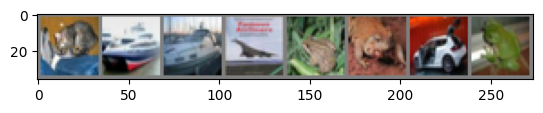

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
Predicted:    cat   ship  plane ship  frog  frog  truck frog 


In [24]:
testset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = net(images)
_, predicted = torch.max(outputs, 1)


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

In [25]:
## Test performance on all clean dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


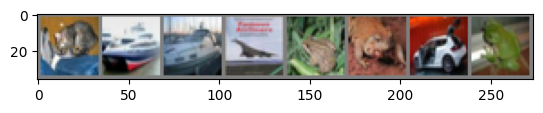

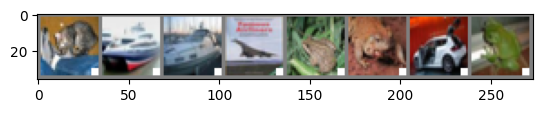

GroundTruth                             :  cat   ship  ship  plane frog  frog  car   frog 
Prediction on Clean Samples             :    cat   ship  plane ship  frog  frog  truck frog 
Prediction on Backdoor-Triggered Samples:    cat   cat   cat   cat   cat   cat   cat   cat  


In [27]:
# Test performance on samples with backdoor triggers

dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

bd_images = images.clone()
for i in range(len(images)):
    bd_images[i] = add_backdoor_trigger(images[i])

bd_outputs = net(bd_images)
_, bd_predicted = torch.max(bd_outputs, 1)
 

# Visualize an example image with the backdoor trigger 
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(bd_images))

print('GroundTruth                             : ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print('Prediction on Clean Samples             :   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))
print('Prediction on Backdoor-Triggered Samples:   ', ' '.join(f'{classes[bd_predicted[j]]:5s}' for j in range(batch_size)))